In [8]:
using ParallelTemperingMonteCarlo
using DelimitedFiles


In [2]:
using Random,Plots

#set random seed - for reproducibility
Random.seed!(1234)

# number of atoms
n_atoms = 13

# temperature grid
ti = 5.
tf = 16.
n_traj = 32

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details
mc_cycles = 30000 #default 20% equilibration cycles on top
mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
pos_ne13 = [[2.825384495892464, 0.928562467914040, 0.505520149314310],
[2.023342172678102,	-2.136126268595355, 0.666071287554958],
[2.033761811732818,	-0.643989413759464, -2.133000349161121],
[0.979777205108572,	2.312002562803556, -1.671909307631893],
[0.962914279874254,	-0.102326586625353, 2.857083360096907],
[0.317957619634043,	2.646768968413408, 1.412132053672896],
[-2.825388342924982, -0.928563755928189, -0.505520471387560],
[-0.317955944853142, -2.646769840660271, -1.412131825293682],
[-0.979776174195320, -2.312003751825495, 1.671909138648006],
[-0.962916072888105, 0.102326392265998,	-2.857083272537599],
[-2.023340541398004, 2.136128558801072,	-0.666071089291685],
[-2.033762834001679, 0.643989905095452, 2.132999911364582],
[0.000002325340981,	0.000000762100600, 0.000000414930733]]

#convert to Bohr
AtoBohr = 1.8897259886
pos_ne13 = pos_ne13 * AtoBohr

length(pos_ne13) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne13 = SphericalBC(radius=5.32*AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne13, bc_ne13)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)



Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[], Float64[])

Total number of moves per MC cycle: 13



equilibration done


MC loop done.


[0.0003210000992725012, 0.00034251120146402004, 0.000363246712118267, 0.00037549026270220653, 0.0003968686540696471, 0.000401123159583441, 0.00040842696009953274, 0.00047134489385135416, 0.00043757214145590727, 0.0005229880661369378, 0.0005497004765235161, 0.000579137622737329, 0.0006128514419126413, 0.0006419387562481418, 0.0007082155744506744, 0.0008089818530269917, 0.0008811260352741997, 0.0009873739164011986, 0.0014354388788637407, 0.0018465838342644556, 0.0024386994468805967, 0.0023835444991865736, 0.0034528635867262505, 0.003000340293216786, 0.0029262366635783485, 0.0030786341028154834, 0.002774383383165998, 0.0026988347766909895, 0.0029162435236186643, 0.0022718305733191225, 0.0021690636172283537, 0.0020037561921587505]
done

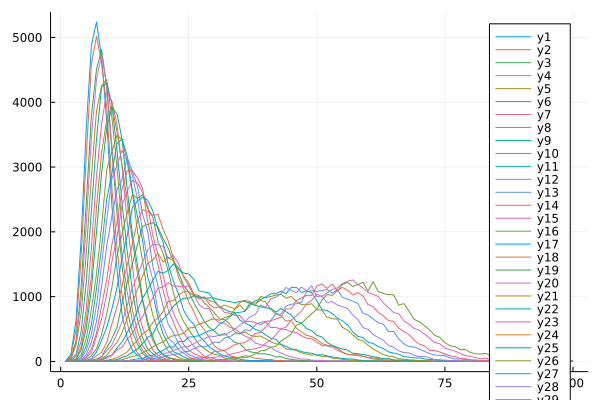

In [3]:
ptmc_run!(mc_states, move_strat, mc_params, pot, ensemble, results; save_ham = true)
#plot(temp.t_grid,results.heat_cap)

data = [results.en_histogram[i] for i in 1:n_traj]
plot(data)

In [10]:
histfile = open("histfile.data","w+")
write(histfile, "this is a test line \n")
writedlm(histfile,results.en_histogram)
close(histfile)



In [24]:
using StaticArrays
histfile = open("histfile.data","r+")
histinfo = readdlm(histfile)[2:end,:]
close(histfile)
testhists = []
for i=1:size(histinfo,1)
    hist = histinfo[i,:]
    push!(testhists,hist)
end


In [25]:
testhists[1]

100-element Vector{Any}:
   11.0
  109.0
  631.0
 1897.0
 3595.0
 4877.0
 5239.0
 4694.0
 3705.0
 2413.0
    ⋮
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0